# Stage 3.  Number of households with internet access and internet access type will be assessed by analysing 3 files with using of additional file with Ireland Administrative regions classification:

•	Number of households with internet access and internet access type per counties and country for 2011

•	Number of households with internet access and internet access type per counties and country for 2016

•	Number of households with internet access and internet access type per counties and country for 2022


In [1]:
##IMPORTING LIBRARIES
import pandas as pd
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Suppress the warnings
import warnings
warnings.filterwarnings('ignore')

# EDA will be structured as:<br>
####     &nbsp;1. Handling data for auxiliary file with Regions classification<br>
####     &nbsp;2. Handling data for file with Internet Types data from 2011 year<br>
####     &nbsp;3. Handling data for file with  Internet Types data from 2016 year<br>
####     &nbsp;4. Handling data for file with  Internet Types data from 2022 year<br>
####     &nbsp;5. Creating 1 DataFrame and exporting it in the csv file<br>

# 1. Handling data for file with Regions classification

In [5]:
#Creating DataFrame with Regions classification

df_reg = pd.read_csv("Regions.csv")
df_reg

,Name of region,Constituent counties,Type of area
0,Border,Cavan,Administrative county
1,NaN,Donegal,Administrative county
2,NaN,Leitrim,Administrative county
3,NaN,Louth,Administrative county
4,NaN,Monaghan,Administrative county
5,NaN,Sligo,Administrative county
6,NaN,NaN,NaN
7,Dublin,Dublin,City
8,NaN,Dún Laoghaire-Rathdown,Administrative county
9,NaN,Fingal,Administrative county


#### Observing that there are NA values in the column with Regions names and empty row after each set of counties

In [6]:
#Using 'ffill' method in the column with Regions to fill NAs with the last valid value 
df_reg["Name of region "] = df_reg["Name of region "].fillna(method='ffill')
df_reg.sample(8)

,Name of region,Constituent counties,Type of area
2,Border,Leitrim,Administrative county
1,Border,Donegal,Administrative county
37,South-West,NaN,NaN
13,Mid-East,Meath,Administrative county
25,Mid-West,Tipperary,Administrative county
11,Dublin,NaN,NaN
9,Dublin,Fingal,Administrative county
28,South-East,Kilkenny,Administrative county


In [7]:
#checking nr of rows with NA values
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Name of region        42 non-null     object
 1   Constituent counties  35 non-null     object
 2    Type of area         35 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [8]:
#Removing rows with NAs and making sure that there no null values left
df_reg = df_reg.dropna()
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 41
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Name of region        35 non-null     object
 1   Constituent counties  35 non-null     object
 2    Type of area         35 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [9]:
#Cheking list of counties
df_reg["Constituent counties"].unique()

array(['Cavan', 'Donegal', 'Leitrim', 'Louth', 'Monaghan', 'Sligo',
       'Dublin', 'Dún Laoghaire-Rathdown', 'Fingal', 'South Dublin',
       'Kildare', 'Meath', 'Wicklow', 'Laois', 'Longford', 'Offaly',
       'Westmeath', 'Clare', 'Limerick', 'North Tipperary ', 'Tipperary',
       'Carlow', 'Kilkenny', 'South Tipperary ', 'Waterford', 'Wexford',
       'Cork', 'Kerry', 'Galway', 'Mayo', 'Roscommon'], dtype=object)

In [10]:
# North Tiperrary and South Tiperrary contain additional space at the end, just remove it
df_reg["Constituent counties"] = df_reg["Constituent counties"].str.replace(f'Tipperary ', 'Tipperary')

In [11]:
#final check
df_reg["Constituent counties"].unique()

array(['Cavan', 'Donegal', 'Leitrim', 'Louth', 'Monaghan', 'Sligo',
       'Dublin', 'Dún Laoghaire-Rathdown', 'Fingal', 'South Dublin',
       'Kildare', 'Meath', 'Wicklow', 'Laois', 'Longford', 'Offaly',
       'Westmeath', 'Clare', 'Limerick', 'North Tipperary', 'Tipperary',
       'Carlow', 'Kilkenny', 'South Tipperary', 'Waterford', 'Wexford',
       'Cork', 'Kerry', 'Galway', 'Mayo', 'Roscommon'], dtype=object)

# 2. Handling data for file with data from 2011 year

In [12]:
#Creating data frame with internet type data per region for 2011 year 
df_it11 = pd.read_csv("SAP2011.csv")
df_it11.head(8)

,Statistic Label,Census Year,Internet,County,UNIT,VALUE
0,Households with Internet access,2011,Broadband,Carlow County,Number,11158
1,Households with Internet access,2011,Broadband,Dublin City,Number,137669
2,Households with Internet access,2011,Broadband,South Dublin,Number,68306
3,Households with Internet access,2011,Broadband,Fingal,Number,73868
4,Households with Internet access,2011,Broadband,Dún Laoghaire-Rathdown,Number,59750
5,Households with Internet access,2011,Broadband,Kildare County,Number,50093
6,Households with Internet access,2011,Broadband,Kilkenny County,Number,19816
7,Households with Internet access,2011,Broadband,Laois County,Number,16003


In [13]:
#Checking unique values
df_it11.County.unique()

array(['Carlow County', 'Dublin City', 'South Dublin', 'Fingal',
       'Dún Laoghaire-Rathdown', 'Kildare County', 'Kilkenny County',
       'Laois County', 'Longford County', 'Louth County', 'Meath County',
       'Offaly County', 'Westmeath County', 'Wexford County',
       'Wicklow County', 'Clare County', 'Cork City', 'Cork County',
       'Kerry County', 'Limerick City', 'Limerick County',
       'North Tipperary', 'South Tipperary', 'Waterford City',
       'Waterford County', 'Galway City', 'Galway County',
       'Leitrim County', 'Mayo County', 'Roscommon County',
       'Sligo County', 'Cavan County', 'Donegal County',
       'Monaghan County'], dtype=object)

##### Counties in this file contain words "County", "City", that are not included in the main clasiification file.
##### In order to be able to use regions instead of counties, as a first step I will remove those words, as well as excessive spaces.
##### Other files might need similar modification, so this is a good reason to create a simple function that remove unnecessary words and/or simbols.

In [14]:
#Method 'replace' will be used
def remove_word(df, word):
        df['County'] = df['County'].str.replace(f' {word}', '')
        return df

In [15]:
#removing unnecessary words and making sure we have no additional spaces
df_it11 = remove_word(df_it11, "County")
df_it11 = remove_word(df_it11, "City")
df_it11 = remove_word(df_it11, " ")
df_it11.County.unique()

array(['Carlow', 'Dublin', 'South Dublin', 'Fingal',
       'Dún Laoghaire-Rathdown', 'Kildare', 'Kilkenny', 'Laois',
       'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford',
       'Wicklow', 'Clare', 'Cork', 'Kerry', 'Limerick', 'North Tipperary',
       'South Tipperary', 'Waterford', 'Galway', 'Leitrim', 'Mayo',
       'Roscommon', 'Sligo', 'Cavan', 'Donegal', 'Monaghan'], dtype=object)

In [16]:
#checking DataFrame for NAs
df_it11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Statistic Label  170 non-null    object
 1   Census Year      170 non-null    int64 
 2   Internet         170 non-null    object
 3   County           170 non-null    object
 4   UNIT             170 non-null    object
 5   VALUE            170 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 8.1+ KB


###### Data frame has no NAs and ready for further modification

Next I will created a function that create new column in current data frame. In this column each row will have according  region for the available county. <br> </br>
Rational behind of creating separate function is that similar transformation will be needed for the file from 2016

In [17]:
#column Region  will be created in the dataFrame

#Function is working with 2 dataframes as arguments:
#for eah element from column "County" in the df_it will check if there is according name in 
#"Constituent counties" column from df_reg
#and if so value from column "Name of region" will be taken for new column

def create_region_column(df_it, df_reg):
    df_it['Region'] = df_it['County'].apply(
        lambda x: df_reg.loc[df_reg['Constituent counties'] == x, 'Name of region '].iloc[0] 
        if x in df_reg['Constituent counties'].to_list() else x)
    return df_it

In [18]:
#applying fuction to current dataframe and checking if new column is created with correct values
df_it11 = create_region_column(df_it11, df_reg)
df_it11.head()

,Statistic Label,Census Year,Internet,County,UNIT,VALUE,Region
0,Households with Internet access,2011,Broadband,Carlow,Number,11158,South-East
1,Households with Internet access,2011,Broadband,Dublin,Number,137669,Dublin
2,Households with Internet access,2011,Broadband,South Dublin,Number,68306,Dublin
3,Households with Internet access,2011,Broadband,Fingal,Number,73868,Dublin
4,Households with Internet access,2011,Broadband,Dún Laoghaire-Rathdown,Number,59750,Dublin


In [19]:
#replacing the counties with regions and checking 
df_it11["County"] = df_it11["Region"]
df_it11.head()

,Statistic Label,Census Year,Internet,County,UNIT,VALUE,Region
0,Households with Internet access,2011,Broadband,South-East,Number,11158,South-East
1,Households with Internet access,2011,Broadband,Dublin,Number,137669,Dublin
2,Households with Internet access,2011,Broadband,Dublin,Number,68306,Dublin
3,Households with Internet access,2011,Broadband,Dublin,Number,73868,Dublin
4,Households with Internet access,2011,Broadband,Dublin,Number,59750,Dublin


In [20]:
#renaming column to the new name and checking
df_it11 = df_it11.rename(columns={'County': 'Name of Region'})
df_it11.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,VALUE,Region
0,Households with Internet access,2011,Broadband,South-East,Number,11158,South-East
1,Households with Internet access,2011,Broadband,Dublin,Number,137669,Dublin
2,Households with Internet access,2011,Broadband,Dublin,Number,68306,Dublin
3,Households with Internet access,2011,Broadband,Dublin,Number,73868,Dublin
4,Households with Internet access,2011,Broadband,Dublin,Number,59750,Dublin


In [21]:
#removing last column to have initial view for the table
df_it11 = df_it11.drop(columns=["Region"])
df_it11.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,VALUE
0,Households with Internet access,2011,Broadband,South-East,Number,11158
1,Households with Internet access,2011,Broadband,Dublin,Number,137669
2,Households with Internet access,2011,Broadband,Dublin,Number,68306
3,Households with Internet access,2011,Broadband,Dublin,Number,73868
4,Households with Internet access,2011,Broadband,Dublin,Number,59750


In [22]:
#last check of the regions[just to be completely sure]
df_it11["Name of Region"].unique()

array(['South-East', 'Dublin', 'Mid-East', 'Midlands', 'Border',
       'Mid-West', 'South-West', 'West'], dtype=object)

In [23]:
#renaming column 'VALUE' and checking the result
df_it11 = df_it11.rename(columns={'VALUE': 'Households with Internet access'})
df_it11.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,Households with Internet access
0,Households with Internet access,2011,Broadband,South-East,Number,11158
1,Households with Internet access,2011,Broadband,Dublin,Number,137669
2,Households with Internet access,2011,Broadband,Dublin,Number,68306
3,Households with Internet access,2011,Broadband,Dublin,Number,73868
4,Households with Internet access,2011,Broadband,Dublin,Number,59750


# 3. Handling data for file with data from 2016 year

In [24]:
#Creating new DataFrame and exploring it
df_it16 = pd.read_csv("SAP2016.csv")
df_it16.head()

,Statistic Label,Census Year,County,Internet,UNIT,VALUE
0,Households with Internet access,2016,Carlow,Broadband,Number,13539
1,Households with Internet access,2016,Carlow,Other,Number,1852
2,Households with Internet access,2016,Carlow,No,Number,4432
3,Households with Internet access,2016,Carlow,Not Stated,Number,642
4,Households with Internet access,2016,Carlow,Total,Number,20465


In [25]:
#re-order columns 
df_it16 = df_it16[['Statistic Label','Census Year','Internet','County','UNIT','VALUE']]
df_it16.head()

,Statistic Label,Census Year,Internet,County,UNIT,VALUE
0,Households with Internet access,2016,Broadband,Carlow,Number,13539
1,Households with Internet access,2016,Other,Carlow,Number,1852
2,Households with Internet access,2016,No,Carlow,Number,4432
3,Households with Internet access,2016,Not Stated,Carlow,Number,642
4,Households with Internet access,2016,Total,Carlow,Number,20465


In [26]:
#checking unique values
df_it16.County.unique()

array(['Carlow', 'Cavan', 'Clare', 'Cork City', 'Cork County', 'Donegal',
       'Dublin City', 'Dún Laoghaire-Rathdown', 'Fingal', 'Galway City',
       'Galway County', 'Kerry', 'Kildare', 'Kilkenny', 'Laois',
       'Leitrim', 'Limerick City and County', 'Longford', 'Louth', 'Mayo',
       'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo',
       'South Dublin', 'Tipperary', 'Waterford City and County',
       'Westmeath', 'Wexford', 'Wicklow'], dtype=object)

In [27]:
#removing all irrelevant words
df_it16 = remove_word(df_it16, "City and County")
df_it16 = remove_word(df_it16, "County")
df_it16 = remove_word(df_it16, "City")
df_it16 = remove_word(df_it16, " ")
df_it16.County.unique()

array(['Carlow', 'Cavan', 'Clare', 'Cork', 'Donegal', 'Dublin',
       'Dún Laoghaire-Rathdown', 'Fingal', 'Galway', 'Kerry', 'Kildare',
       'Kilkenny', 'Laois', 'Leitrim', 'Limerick', 'Longford', 'Louth',
       'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo',
       'South Dublin', 'Tipperary', 'Waterford', 'Westmeath', 'Wexford',
       'Wicklow'], dtype=object)

In [28]:
#using function for Regions
df_it16 = create_region_column(df_it16, df_reg)
df_it16.head()

,Statistic Label,Census Year,Internet,County,UNIT,VALUE,Region
0,Households with Internet access,2016,Broadband,Carlow,Number,13539,South-East
1,Households with Internet access,2016,Other,Carlow,Number,1852,South-East
2,Households with Internet access,2016,No,Carlow,Number,4432,South-East
3,Households with Internet access,2016,Not Stated,Carlow,Number,642,South-East
4,Households with Internet access,2016,Total,Carlow,Number,20465,South-East


In [29]:
#replacing the counties with regions and checking 
df_it16["County"] = df_it16["Region"]
df_it16.head()

,Statistic Label,Census Year,Internet,County,UNIT,VALUE,Region
0,Households with Internet access,2016,Broadband,South-East,Number,13539,South-East
1,Households with Internet access,2016,Other,South-East,Number,1852,South-East
2,Households with Internet access,2016,No,South-East,Number,4432,South-East
3,Households with Internet access,2016,Not Stated,South-East,Number,642,South-East
4,Households with Internet access,2016,Total,South-East,Number,20465,South-East


In [30]:
#renaming column to the new name and checking
df_it16 = df_it16.rename(columns={'County': 'Name of Region'})
df_it16.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,VALUE,Region
0,Households with Internet access,2016,Broadband,South-East,Number,13539,South-East
1,Households with Internet access,2016,Other,South-East,Number,1852,South-East
2,Households with Internet access,2016,No,South-East,Number,4432,South-East
3,Households with Internet access,2016,Not Stated,South-East,Number,642,South-East
4,Households with Internet access,2016,Total,South-East,Number,20465,South-East


In [31]:
#removing last column to have initial view for the table

df_it16 = df_it16.drop(columns=["Region"])
df_it16.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,VALUE
0,Households with Internet access,2016,Broadband,South-East,Number,13539
1,Households with Internet access,2016,Other,South-East,Number,1852
2,Households with Internet access,2016,No,South-East,Number,4432
3,Households with Internet access,2016,Not Stated,South-East,Number,642
4,Households with Internet access,2016,Total,South-East,Number,20465


In [32]:
#Last check for obtained data
df_it16["Name of Region"].unique()

array(['South-East', 'Border', 'Mid-West', 'South-West', 'Dublin', 'West',
       'Mid-East', 'Midlands'], dtype=object)

In [33]:
#renaming column 'VALUE' and checking the result
df_it16 = df_it16.rename(columns={'VALUE': 'Households with Internet access'})
df_it16.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,Households with Internet access
0,Households with Internet access,2016,Broadband,South-East,Number,13539
1,Households with Internet access,2016,Other,South-East,Number,1852
2,Households with Internet access,2016,No,South-East,Number,4432
3,Households with Internet access,2016,Not Stated,South-East,Number,642
4,Households with Internet access,2016,Total,South-East,Number,20465


# 4. Handling data for file with data from 2022 year

In [34]:
#Creating new DataFrame and exploring it

df_it22 = pd.read_csv("SAP2022.csv")
df_it22.head()

,Statistic Label,Census Year,Internet,NUTS 3 Region,UNIT,VALUE
0,Households with Internet access,2022,Broadband,Ireland,Number,1457883
1,Households with Internet access,2022,Broadband,Border,Number,116928
2,Households with Internet access,2022,Broadband,West,Number,134086
3,Households with Internet access,2022,Broadband,Mid-West,Number,137622
4,Households with Internet access,2022,Broadband,South-East,Number,124415


This file already has regions names and correct order of columns, so just renaming columns with regions and Values

In [35]:
#renaming column 'NUTS 3 Region' and checking the result
df_it22 = df_it22.rename(columns={'NUTS 3 Region': 'Name of Region'})

In [36]:
#renaming column 'VALUE' and checking the result
df_it22 = df_it22.rename(columns={'VALUE': 'Households with Internet access'})
df_it22.head()

,Statistic Label,Census Year,Internet,Name of Region,UNIT,Households with Internet access
0,Households with Internet access,2022,Broadband,Ireland,Number,1457883
1,Households with Internet access,2022,Broadband,Border,Number,116928
2,Households with Internet access,2022,Broadband,West,Number,134086
3,Households with Internet access,2022,Broadband,Mid-West,Number,137622
4,Households with Internet access,2022,Broadband,South-East,Number,124415


In [37]:
#checking regions to be from the same range with other files 
df_it22["Name of Region"].unique()

array(['Ireland', 'Border', 'West', 'Mid-West', 'South-East',
       'South-West', 'Dublin', 'Mid-East', 'Midlands'], dtype=object)

# 5. Creating 1 DataFrame and exporting it in the csv file "SAP.csv"

In [38]:
#checking nr of rows in the 1st data frame
df_it11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Statistic Label                  170 non-null    object
 1   Census Year                      170 non-null    int64 
 2   Internet                         170 non-null    object
 3   Name of Region                   170 non-null    object
 4   UNIT                             170 non-null    object
 5   Households with Internet access  170 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 8.1+ KB


In [39]:
#checking nr of rows in the 2nd data frame

df_it16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Statistic Label                  155 non-null    object
 1   Census Year                      155 non-null    int64 
 2   Internet                         155 non-null    object
 3   Name of Region                   155 non-null    object
 4   UNIT                             155 non-null    object
 5   Households with Internet access  155 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 7.4+ KB


In [40]:
#checking nr of rows in the 3rd data frame

df_it22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Statistic Label                  45 non-null     object
 1   Census Year                      45 non-null     int64 
 2   Internet                         45 non-null     object
 3   Name of Region                   45 non-null     object
 4   UNIT                             45 non-null     object
 5   Households with Internet access  45 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ KB


In [41]:
#brief calc for expected result
170+155+45

370

In [42]:
#applying concatination for all 3 DataFrames
df_it = pd.concat([df_it11, df_it16,df_it22], ignore_index=True)
df_it.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Statistic Label                  370 non-null    object
 1   Census Year                      370 non-null    int64 
 2   Internet                         370 non-null    object
 3   Name of Region                   370 non-null    object
 4   UNIT                             370 non-null    object
 5   Households with Internet access  370 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 17.5+ KB


In [43]:
#Cheking if there is no mistakes or misspellings in the regions names
df_it["Name of Region"].unique()

array(['South-East', 'Dublin', 'Mid-East', 'Midlands', 'Border',
       'Mid-West', 'South-West', 'West', 'Ireland'], dtype=object)

In [44]:
# Group the DataFrame by the all columns except Value
#Rational: to have 1 row/value for each group of categories
df_grouped = df_it.groupby(['Statistic Label', 'Census Year', 'Internet', 'Name of Region', 'UNIT'])

In [45]:
# Aggregate the data in each group by summarising values in each group
df_grouped = df_grouped.agg({'Households with Internet access': 'sum'})

In [46]:
# Reset the indexes of the grouped DataFrame
df_grouped = df_grouped.reset_index()
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Statistic Label                  125 non-null    object
 1   Census Year                      125 non-null    int64 
 2   Internet                         125 non-null    object
 3   Name of Region                   125 non-null    object
 4   UNIT                             125 non-null    object
 5   Households with Internet access  125 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 6.0+ KB


In [47]:
#selecting random rows for wider observation
df_grouped.sample(15)

,Statistic Label,Census Year,Internet,Name of Region,UNIT,Households with Internet access
41,Households with Internet access,2016,Broadband,Dublin,Number,383625
28,Households with Internet access,2011,Other,Midlands,Number,11602
109,Households with Internet access,2022,Other,Ireland,Number,73165
62,Households with Internet access,2016,Not Stated,South-West,Number,7058
54,Households with Internet access,2016,No,South-West,Number,50240
71,Households with Internet access,2016,Other,West,Number,17325
0,Households with Internet access,2011,Broadband,Border,Number,106183
32,Households with Internet access,2011,Total,Border,Number,185170
4,Households with Internet access,2011,Broadband,Midlands,Number,55102
33,Households with Internet access,2011,Total,Dublin,Number,466461


In [51]:
pop_grouped = df_grouped.groupby("Census Year")["Households with Internet access"].sum()
pop_grouped

Census Year
2011    3298816
2016    3395330
2022    7346912
Name: Households with Internet access, dtype: int64

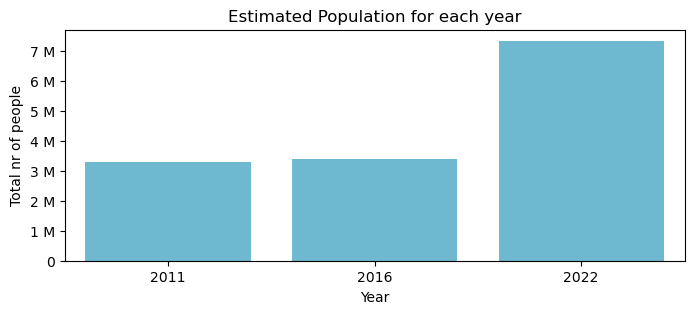

In [53]:
import matplotlib.ticker as ticker
# Create a bar plot of the sum of population for each year
plt.figure(figsize=(8, 3))
sns.barplot(x=pop_grouped.index, y=pop_grouped.values, color="#5ec0e0")
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel("Year")
plt.ylabel("Total nr of people")
plt.title("Estimated Population for each year")
plt.show()

In [48]:
#Export DataFrame to a csv File
df_grouped.to_csv("SAP_c.csv", index = False)